In [0]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from keras.layers import AveragePooling2D, Activation, Lambda, Add, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.regularizers import l2
import keras.backend as K

from utils import plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
from oct_conv2d import OctConv2D

Using TensorFlow backend.


# Parameters

In [2]:
STD_SIZE = (32, 32)
BATCH_SIZE = 128
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# Data preparation

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE)

# Baseline

## Model

In [5]:
inputs = Input(shape=(32, 32, 3))
y = Conv2D(192, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
y = Conv2D(160, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(96, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(y)
y = Conv2D(192, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(192, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(192, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(y)
y = Conv2D(192, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(192, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(10, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
outputs = GlobalAveragePooling2D()(y)
outputs = Activation('softmax')(outputs)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

W0714 22:45:59.716312   808 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 22:45:59.747314   808 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 22:45:59.750314   808 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 22:45:59.789316   808 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0714 22:45:59.876321   808 depreca

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       14592     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 160)       30880     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 96)        15456     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       460992    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 192)       37056     
__________

In [7]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=200, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'nin_cifar_alpha_0', monitor='val_acc', save_best_only=True, verbose=1)
              ])

with open(PATH + 'nin_cifar_alpha_0_history', 'wb') as f:
    pickle.dump(history.history, f)

W0714 22:46:48.215172   808 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0714 22:46:48.353180   808 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/200
 - 105s - loss: 2.2207 - acc: 0.2097 - val_loss: 2.2695 - val_acc: 0.2264

Epoch 00001: val_acc improved from -inf to 0.22640, saving model to nin_cifar_alpha_0
Epoch 2/200
 - 102s - loss: 2.1195 - acc: 0.2648 - val_loss: 2.1557 - val_acc: 0.2483

Epoch 00002: val_acc improved from 0.22640 to 0.24830, saving model to nin_cifar_alpha_0
Epoch 3/200
 - 102s - loss: 2.0522 - acc: 0.2956 - val_loss: 2.0986 - val_acc: 0.2619

Epoch 00003: val_acc improved from 0.24830 to 0.26190, saving model to nin_cifar_alpha_0
Epoch 4/200
 - 102s - loss: 2.0129 - acc: 0.3103 - val_loss: 1.9934 - val_acc: 0.3000

Epoch 00004: val_acc improved from 0.26190 to 0.30000, saving model to nin_cifar_alpha_0
Epoch 5/200
 - 102s - loss: 1.9826 - acc: 0.3247 - val_loss: 2.1212 - val_acc: 0.2998

Epoch 00005: val_acc did not improve from 0.30000
Epoch 6/200
 - 102s - loss: 1.9560 - acc: 0.3363 - val_loss: 1.9243 - val_acc: 0.3432

Epoch 00006: val_acc improved from 0.30000 to 0.34320, saving model to nin_

 - 104s - loss: 1.6106 - acc: 0.4890 - val_loss: 1.7331 - val_acc: 0.4927

Epoch 00054: val_acc did not improve from 0.51060
Epoch 55/200
 - 103s - loss: 1.6116 - acc: 0.4894 - val_loss: 1.5406 - val_acc: 0.5114

Epoch 00055: val_acc improved from 0.51060 to 0.51140, saving model to nin_cifar_alpha_0
Epoch 56/200
 - 102s - loss: 1.6095 - acc: 0.4909 - val_loss: 1.6163 - val_acc: 0.5095

Epoch 00056: val_acc did not improve from 0.51140
Epoch 57/200
 - 103s - loss: 1.6090 - acc: 0.4909 - val_loss: 1.5740 - val_acc: 0.5068

Epoch 00057: val_acc did not improve from 0.51140
Epoch 58/200
 - 102s - loss: 1.6067 - acc: 0.4936 - val_loss: 1.5882 - val_acc: 0.5155

Epoch 00058: val_acc improved from 0.51140 to 0.51550, saving model to nin_cifar_alpha_0
Epoch 59/200
 - 102s - loss: 1.6054 - acc: 0.4939 - val_loss: 1.5390 - val_acc: 0.5252

Epoch 00059: val_acc improved from 0.51550 to 0.52520, saving model to nin_cifar_alpha_0
Epoch 60/200
 - 103s - loss: 1.6007 - acc: 0.4953 - val_loss: 1.6357


Epoch 00111: val_acc did not improve from 0.53640
Epoch 112/200
 - 102s - loss: 1.6010 - acc: 0.5164 - val_loss: 1.6197 - val_acc: 0.5176

Epoch 00112: val_acc did not improve from 0.53640
Epoch 113/200
 - 102s - loss: 1.6003 - acc: 0.5175 - val_loss: 1.8038 - val_acc: 0.5054

Epoch 00113: val_acc did not improve from 0.53640
Epoch 114/200
 - 102s - loss: 1.5969 - acc: 0.5178 - val_loss: 1.5696 - val_acc: 0.5376

Epoch 00114: val_acc improved from 0.53640 to 0.53760, saving model to nin_cifar_alpha_0
Epoch 115/200
 - 102s - loss: 1.5967 - acc: 0.5202 - val_loss: 1.6388 - val_acc: 0.5269

Epoch 00115: val_acc did not improve from 0.53760
Epoch 116/200
 - 102s - loss: 1.5988 - acc: 0.5192 - val_loss: 1.6603 - val_acc: 0.5298

Epoch 00116: val_acc did not improve from 0.53760
Epoch 117/200
 - 102s - loss: 1.6010 - acc: 0.5184 - val_loss: 1.8476 - val_acc: 0.4914

Epoch 00117: val_acc did not improve from 0.53760
Epoch 118/200
 - 102s - loss: 1.5965 - acc: 0.5213 - val_loss: 1.6045 - val_

 - 102s - loss: 1.6334 - acc: 0.5236 - val_loss: 1.6060 - val_acc: 0.5420

Epoch 00169: val_acc did not improve from 0.55870
Epoch 170/200
 - 102s - loss: 1.6348 - acc: 0.5245 - val_loss: 1.7225 - val_acc: 0.5248

Epoch 00170: val_acc did not improve from 0.55870
Epoch 171/200
 - 102s - loss: 1.6368 - acc: 0.5239 - val_loss: 1.6136 - val_acc: 0.5487

Epoch 00171: val_acc did not improve from 0.55870
Epoch 172/200
 - 102s - loss: 1.6343 - acc: 0.5226 - val_loss: 1.5912 - val_acc: 0.5497

Epoch 00172: val_acc did not improve from 0.55870
Epoch 173/200
 - 102s - loss: 1.6346 - acc: 0.5278 - val_loss: 1.5694 - val_acc: 0.5419

Epoch 00173: val_acc did not improve from 0.55870
Epoch 174/200
 - 102s - loss: 1.6325 - acc: 0.5259 - val_loss: 1.6748 - val_acc: 0.5387

Epoch 00174: val_acc did not improve from 0.55870
Epoch 175/200
 - 102s - loss: 1.6377 - acc: 0.5222 - val_loss: 1.7197 - val_acc: 0.5284

Epoch 00175: val_acc did not improve from 0.55870
Epoch 176/200
 - 102s - loss: 1.6349 - ac

## Results

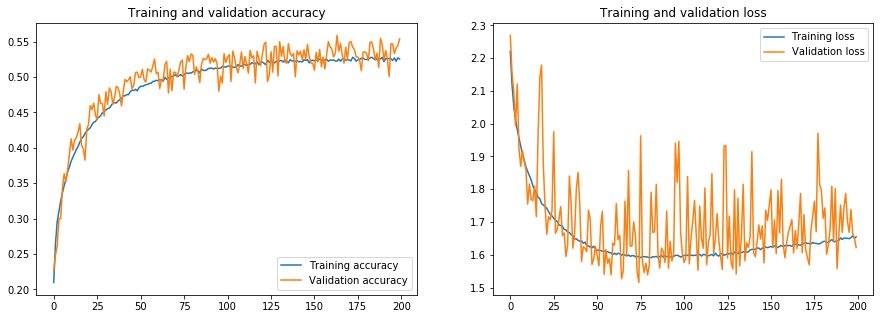

In [8]:
plot_accuracy_and_loss(history)

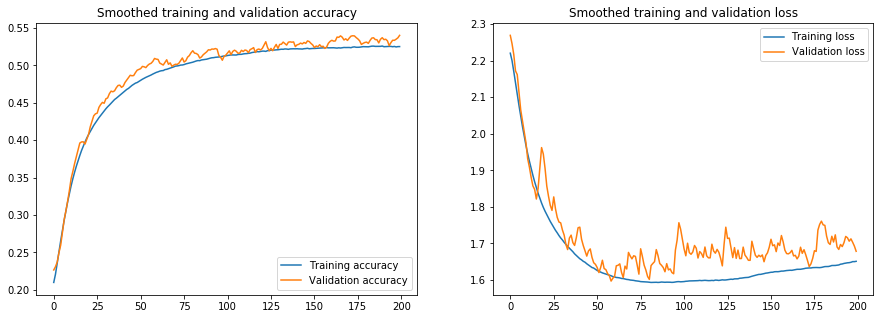

In [9]:
plot_smoothed_acc_and_loss(history, 0.8)

In [10]:
model = load_model(PATH + 'nin_cifar_alpha_0')
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 6s 593us/step


[1.6054538970947265, 0.5587]

# OctConv

In [8]:
for alpha in [0.125, 0.25, 0.5, 0.75]:
    inputs = Input(shape=(32, 32, 3))
    low = AveragePooling2D(2)(inputs)
    
    high, low = OctConv2D(filters=192, kernel_size=(5, 5), alpha=alpha, kernel_regularizer=l2(1e-4))([inputs, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
    high, low = OctConv2D(filters=160, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=96, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=192, kernel_size=(5, 5), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
    high, low = OctConv2D(filters=192, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=192, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=192, kernel_size=(3, 3), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
            
    high = Conv2D(192, padding='same', kernel_size=(1, 1), kernel_regularizer=l2(1e-4))(high)
    low = Conv2D(192, padding='same', kernel_size=(1, 1), kernel_regularizer=l2(1e-4))(low)
    low = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low)
    x = Add()([high, low])
    x = Activation('relu')(x)
    
    x = Conv2D(filters=10, kernel_size=(1, 1), kernel_regularizer=l2(1e-4))(x)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=1e-4),
                  metrics=['accuracy'])
    history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + f'nin_cifar_alpha_{alpha}_test', monitor='val_acc', save_best_only=True, verbose=1)
              ])

    with open(PATH + f'nin_alpha_{alpha}_history_test', 'wb') as f:
        pickle.dump(history.history, f)

W0718 09:18:29.637822  5432 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0718 09:18:29.643823  5432 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0718 09:18:30.924448  5432 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as

Epoch 1/100
 - 148s - loss: 2.2047 - acc: 0.2349 - val_loss: 2.1471 - val_acc: 0.2626

Epoch 00001: val_acc improved from -inf to 0.26262, saving model to nin_cifar_alpha_0.125_test
Epoch 2/100
 - 130s - loss: 2.0445 - acc: 0.2972 - val_loss: 1.9228 - val_acc: 0.3460

Epoch 00002: val_acc improved from 0.26262 to 0.34603, saving model to nin_cifar_alpha_0.125_test
Epoch 3/100
 - 129s - loss: 1.9720 - acc: 0.3255 - val_loss: 1.7935 - val_acc: 0.4068

Epoch 00003: val_acc improved from 0.34603 to 0.40681, saving model to nin_cifar_alpha_0.125_test
Epoch 4/100
 - 129s - loss: 1.9220 - acc: 0.3448 - val_loss: 1.7572 - val_acc: 0.4016

Epoch 00004: val_acc did not improve from 0.40681
Epoch 5/100
 - 129s - loss: 1.8834 - acc: 0.3614 - val_loss: 1.7551 - val_acc: 0.4235

Epoch 00005: val_acc improved from 0.40681 to 0.42352, saving model to nin_cifar_alpha_0.125_test
Epoch 6/100
 - 129s - loss: 1.8477 - acc: 0.3729 - val_loss: 1.6711 - val_acc: 0.4329

Epoch 00006: val_acc improved from 0.42

 - 129s - loss: 1.1910 - acc: 0.6327 - val_loss: 1.1752 - val_acc: 0.6539

Epoch 00053: val_acc did not improve from 0.66542
Epoch 54/100
 - 129s - loss: 1.1848 - acc: 0.6340 - val_loss: 1.1172 - val_acc: 0.6574

Epoch 00054: val_acc did not improve from 0.66542
Epoch 55/100
 - 129s - loss: 1.1786 - acc: 0.6361 - val_loss: 1.1564 - val_acc: 0.6589

Epoch 00055: val_acc did not improve from 0.66542
Epoch 56/100
 - 129s - loss: 1.1688 - acc: 0.6385 - val_loss: 1.1508 - val_acc: 0.6572

Epoch 00056: val_acc did not improve from 0.66542
Epoch 57/100
 - 129s - loss: 1.1617 - acc: 0.6432 - val_loss: 1.1177 - val_acc: 0.6730

Epoch 00057: val_acc improved from 0.66542 to 0.67301, saving model to nin_cifar_alpha_0.125_test
Epoch 58/100
 - 129s - loss: 1.1593 - acc: 0.6409 - val_loss: 1.2075 - val_acc: 0.6485

Epoch 00058: val_acc did not improve from 0.67301
Epoch 59/100
 - 129s - loss: 1.1492 - acc: 0.6477 - val_loss: 1.1846 - val_acc: 0.6513

Epoch 00059: val_acc did not improve from 0.67301

 - 115s - loss: 1.7981 - acc: 0.4038 - val_loss: 1.6345 - val_acc: 0.4627

Epoch 00008: val_acc did not improve from 0.47822
Epoch 9/100
 - 115s - loss: 1.7554 - acc: 0.4205 - val_loss: 1.5793 - val_acc: 0.4845

Epoch 00009: val_acc improved from 0.47822 to 0.48450, saving model to nin_cifar_alpha_0.25_test
Epoch 10/100
 - 115s - loss: 1.7392 - acc: 0.4274 - val_loss: 1.6029 - val_acc: 0.4723

Epoch 00010: val_acc did not improve from 0.48450
Epoch 11/100
 - 115s - loss: 1.7133 - acc: 0.4364 - val_loss: 1.6806 - val_acc: 0.4516

Epoch 00011: val_acc did not improve from 0.48450
Epoch 12/100
 - 115s - loss: 1.6919 - acc: 0.4491 - val_loss: 1.5555 - val_acc: 0.4996

Epoch 00012: val_acc improved from 0.48450 to 0.49959, saving model to nin_cifar_alpha_0.25_test
Epoch 13/100
 - 115s - loss: 1.6638 - acc: 0.4573 - val_loss: 1.4973 - val_acc: 0.5137

Epoch 00013: val_acc improved from 0.49959 to 0.51368, saving model to nin_cifar_alpha_0.25_test
Epoch 14/100
 - 115s - loss: 1.6428 - acc: 0.

 - 115s - loss: 1.1540 - acc: 0.6521 - val_loss: 1.0604 - val_acc: 0.6952

Epoch 00060: val_acc improved from 0.69277 to 0.69520, saving model to nin_cifar_alpha_0.25_test
Epoch 61/100
 - 115s - loss: 1.1463 - acc: 0.6549 - val_loss: 1.0737 - val_acc: 0.6867

Epoch 00061: val_acc did not improve from 0.69520
Epoch 62/100
 - 115s - loss: 1.1394 - acc: 0.6577 - val_loss: 1.0473 - val_acc: 0.6956

Epoch 00062: val_acc improved from 0.69520 to 0.69560, saving model to nin_cifar_alpha_0.25_test
Epoch 63/100
 - 115s - loss: 1.1371 - acc: 0.6593 - val_loss: 1.0048 - val_acc: 0.7113

Epoch 00063: val_acc improved from 0.69560 to 0.71130, saving model to nin_cifar_alpha_0.25_test
Epoch 64/100
 - 115s - loss: 1.1259 - acc: 0.6607 - val_loss: 1.0928 - val_acc: 0.6856

Epoch 00064: val_acc did not improve from 0.71130
Epoch 65/100
 - 115s - loss: 1.1183 - acc: 0.6652 - val_loss: 1.0009 - val_acc: 0.7072

Epoch 00065: val_acc did not improve from 0.71130
Epoch 66/100
 - 115s - loss: 1.1150 - acc: 0


Epoch 00013: val_acc improved from 0.50790 to 0.51580, saving model to nin_cifar_alpha_0.5_test
Epoch 14/100
 - 84s - loss: 1.6479 - acc: 0.4694 - val_loss: 1.4541 - val_acc: 0.5428

Epoch 00014: val_acc improved from 0.51580 to 0.54285, saving model to nin_cifar_alpha_0.5_test
Epoch 15/100
 - 84s - loss: 1.6256 - acc: 0.4771 - val_loss: 1.4346 - val_acc: 0.5462

Epoch 00015: val_acc improved from 0.54285 to 0.54619, saving model to nin_cifar_alpha_0.5_test
Epoch 16/100
 - 84s - loss: 1.6056 - acc: 0.4872 - val_loss: 1.4201 - val_acc: 0.5519

Epoch 00016: val_acc improved from 0.54619 to 0.55186, saving model to nin_cifar_alpha_0.5_test
Epoch 17/100
 - 84s - loss: 1.5859 - acc: 0.4941 - val_loss: 1.4902 - val_acc: 0.5339

Epoch 00017: val_acc did not improve from 0.55186
Epoch 18/100
 - 84s - loss: 1.5659 - acc: 0.5041 - val_loss: 1.4609 - val_acc: 0.5406

Epoch 00018: val_acc did not improve from 0.55186
Epoch 19/100
 - 84s - loss: 1.5554 - acc: 0.5070 - val_loss: 1.4087 - val_acc: 0


Epoch 00067: val_acc did not improve from 0.72235
Epoch 68/100
 - 84s - loss: 1.0937 - acc: 0.6806 - val_loss: 1.0399 - val_acc: 0.7051

Epoch 00068: val_acc did not improve from 0.72235
Epoch 69/100
 - 84s - loss: 1.0871 - acc: 0.6836 - val_loss: 1.1565 - val_acc: 0.6799

Epoch 00069: val_acc did not improve from 0.72235
Epoch 70/100
 - 84s - loss: 1.0794 - acc: 0.6874 - val_loss: 1.0652 - val_acc: 0.7038

Epoch 00070: val_acc did not improve from 0.72235
Epoch 71/100
 - 84s - loss: 1.0764 - acc: 0.6873 - val_loss: 0.9920 - val_acc: 0.7171

Epoch 00071: val_acc did not improve from 0.72235
Epoch 72/100
 - 84s - loss: 1.0770 - acc: 0.6880 - val_loss: 1.0170 - val_acc: 0.7163

Epoch 00072: val_acc did not improve from 0.72235
Epoch 73/100
 - 84s - loss: 1.0682 - acc: 0.6902 - val_loss: 0.9759 - val_acc: 0.7280

Epoch 00073: val_acc improved from 0.72235 to 0.72802, saving model to nin_cifar_alpha_0.5_test
Epoch 74/100
 - 84s - loss: 1.0692 - acc: 0.6903 - val_loss: 1.1010 - val_acc: 0.

 - 63s - loss: 1.4997 - acc: 0.5186 - val_loss: 1.3524 - val_acc: 0.5732

Epoch 00021: val_acc did not improve from 0.58165
Epoch 22/100
 - 63s - loss: 1.4791 - acc: 0.5294 - val_loss: 1.3775 - val_acc: 0.5674

Epoch 00022: val_acc did not improve from 0.58165
Epoch 23/100
 - 63s - loss: 1.4664 - acc: 0.5354 - val_loss: 1.3546 - val_acc: 0.5720

Epoch 00023: val_acc did not improve from 0.58165
Epoch 24/100
 - 63s - loss: 1.4548 - acc: 0.5368 - val_loss: 1.2978 - val_acc: 0.5975

Epoch 00024: val_acc improved from 0.58165 to 0.59755, saving model to nin_cifar_alpha_0.75_test
Epoch 25/100
 - 63s - loss: 1.4391 - acc: 0.5437 - val_loss: 1.3859 - val_acc: 0.5693

Epoch 00025: val_acc did not improve from 0.59755
Epoch 26/100
 - 63s - loss: 1.4304 - acc: 0.5481 - val_loss: 1.2758 - val_acc: 0.5983

Epoch 00026: val_acc improved from 0.59755 to 0.59826, saving model to nin_cifar_alpha_0.75_test
Epoch 27/100
 - 63s - loss: 1.4090 - acc: 0.5534 - val_loss: 1.2849 - val_acc: 0.6035

Epoch 0002

 - 63s - loss: 1.0441 - acc: 0.6926 - val_loss: 1.0281 - val_acc: 0.7094

Epoch 00076: val_acc did not improve from 0.71789
Epoch 77/100
 - 63s - loss: 1.0440 - acc: 0.6942 - val_loss: 1.0582 - val_acc: 0.7020

Epoch 00077: val_acc did not improve from 0.71789
Epoch 78/100
 - 63s - loss: 1.0371 - acc: 0.6940 - val_loss: 1.0432 - val_acc: 0.7066

Epoch 00078: val_acc did not improve from 0.71789
Epoch 79/100
 - 63s - loss: 1.0338 - acc: 0.7001 - val_loss: 0.9972 - val_acc: 0.7171

Epoch 00079: val_acc did not improve from 0.71789
Epoch 80/100
 - 63s - loss: 1.0290 - acc: 0.6975 - val_loss: 0.9955 - val_acc: 0.7129

Epoch 00080: val_acc did not improve from 0.71789
Epoch 81/100
 - 63s - loss: 1.0274 - acc: 0.7008 - val_loss: 0.9413 - val_acc: 0.7283

Epoch 00081: val_acc improved from 0.71789 to 0.72832, saving model to nin_cifar_alpha_0.75_test
Epoch 82/100
 - 63s - loss: 1.0265 - acc: 0.7008 - val_loss: 0.9270 - val_acc: 0.7386

Epoch 00082: val_acc improved from 0.72832 to 0.73855, sa

For alpha = 0:
 Max test accuracy = 0.5587



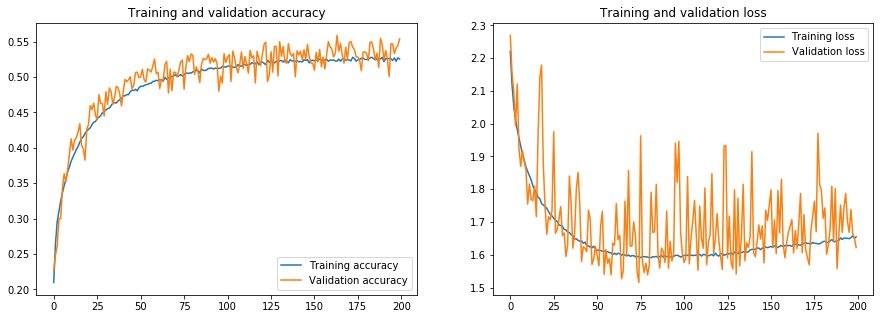

For alpha = 0.125:
 Max test accuracy = 0.7663



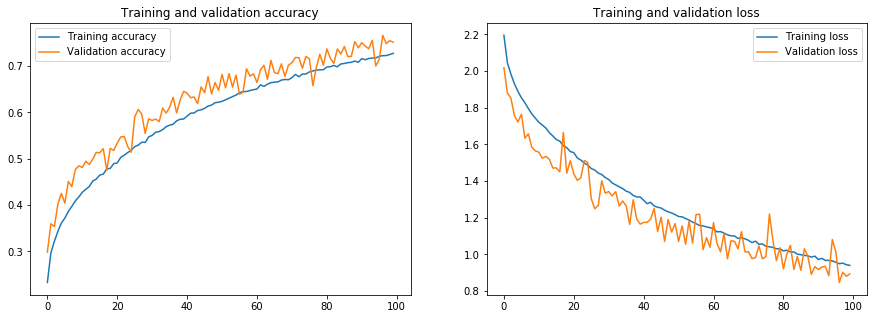

For alpha = 0.25:
 Max test accuracy = 0.7621



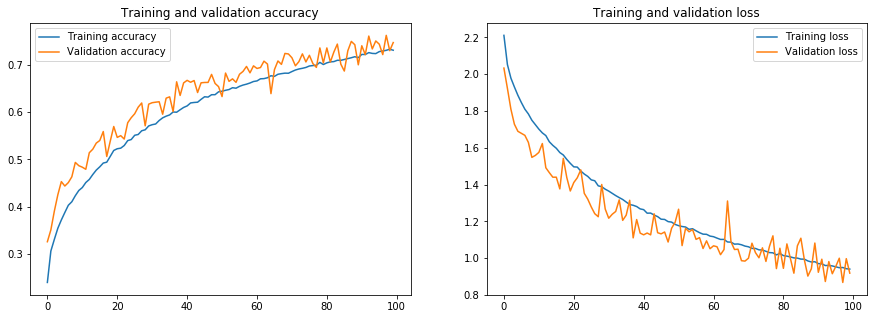

For alpha = 0.5:
 Max test accuracy = 0.7558



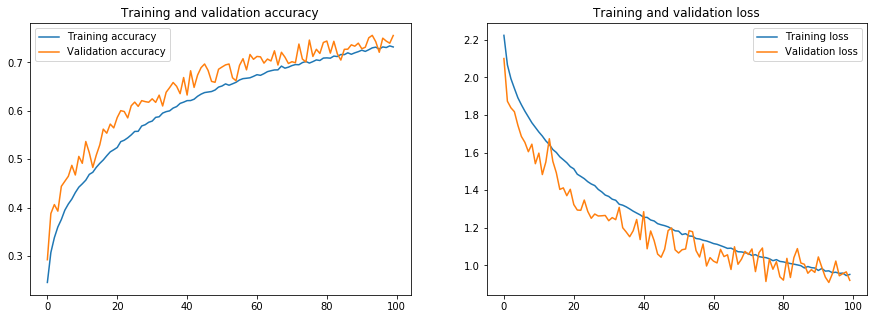

For alpha = 0.75:
 Max test accuracy = 0.75



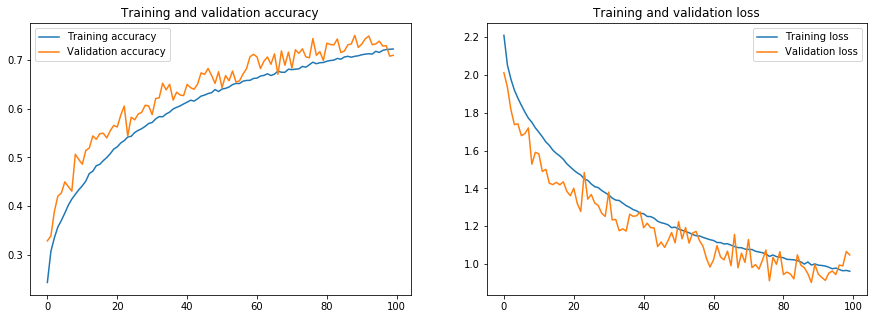

In [9]:
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'nin_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(history['val_acc']):.04}\n")

    plot_accuracy_and_loss(history)

In [3]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

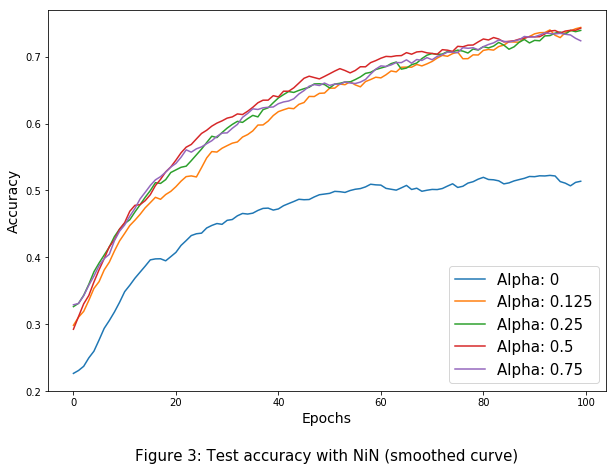

In [91]:
fig, ax = plt.subplots(figsize=(10, 7))

for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'nin_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        ax.plot(smooth_curve(history['val_acc'][:100]), label=f"Alpha: {alpha}", )

ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title("Figure 3: Test accuracy with NiN (smoothed curve)", size=15, y=-0.2)
ax.legend(prop={'size': 15})

plt.show()

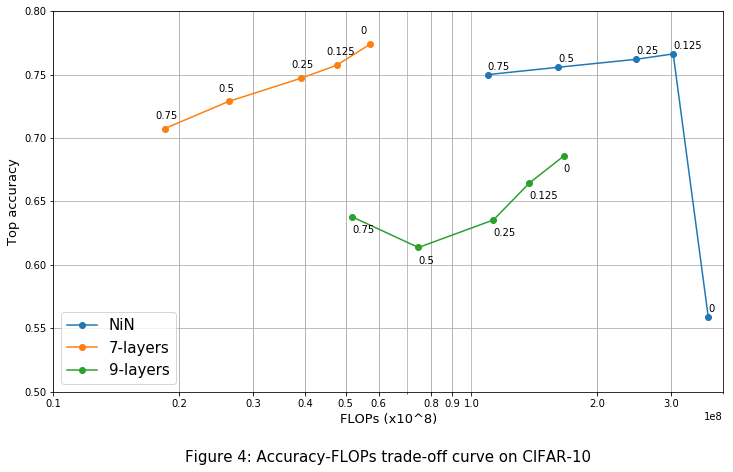

In [88]:
import matplotlib.ticker

nin_acc = []
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'nin_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        nin_acc.append(max(history['val_acc']))
nin_flops = [368762880, 303941280, 247762560, 161333760, 109476480]

layers_7_acc = []
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'7_layers_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        layers_7_acc.append(max(history['val_acc']))
layers_7_flops = [57255414, 47561334, 39159798, 26234358, 18479094]

layers_9_acc = []
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'9_layers_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        layers_9_acc.append(max(history['val_acc']))
layers_9_flops = [166351094, 137709494, 112886774, 74697974, 51784694]

fig, ax = plt.subplots(figsize=(12, 7))

ax.grid(True, which="both")
ax.semilogx(nin_flops, nin_acc, label="NiN", marker='o')
ax.semilogx(layers_7_flops, layers_7_acc, label="7-layers", marker='o')
ax.semilogx(layers_9_flops, layers_9_acc, label="9-layers", marker='o')
ax.set_xlim([10000000, 400000000])
ax.set_ylim([0.5, .8])
ax.set_xlabel('FLOPs (x10^8)', size=13)
ax.set_ylabel('Top accuracy', size=13)
ax.legend(loc='lower left', prop={'size': 15})
ax.set_xticks([1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 8e7, 9e7, 1e8, 2e8, 3e8])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

size = fig.get_size_inches()*fig.dpi # get fig size in pixels
ax.set_title('Figure 4: Accuracy-FLOPs trade-off curve on CIFAR-10', y=-0.2, size=15)

for i, alpha in enumerate([0, 0.125, 0.25, 0.5, 0.75]):
    ax.annotate(f"{alpha}", (nin_flops[i], nin_acc[i]), xytext=(0, 5), textcoords='offset points')
    ax.annotate(f"{alpha}", (layers_7_flops[i], layers_7_acc[i]), xytext=(-10, 10), textcoords='offset points')
    ax.annotate(f"{alpha}", (layers_9_flops[i], layers_9_acc[i]), xytext=(0, -16), textcoords='offset points')


plt.show()